1 2136916


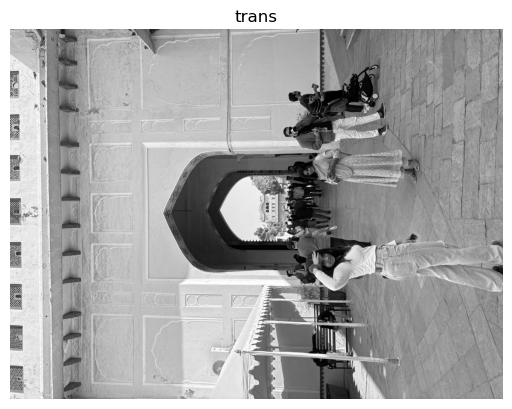

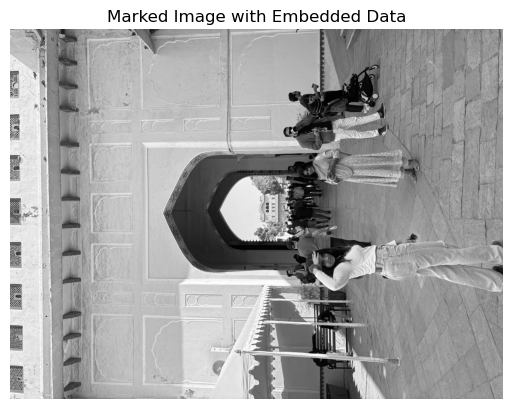

Data embedded. Image shape: (4284, 5712)


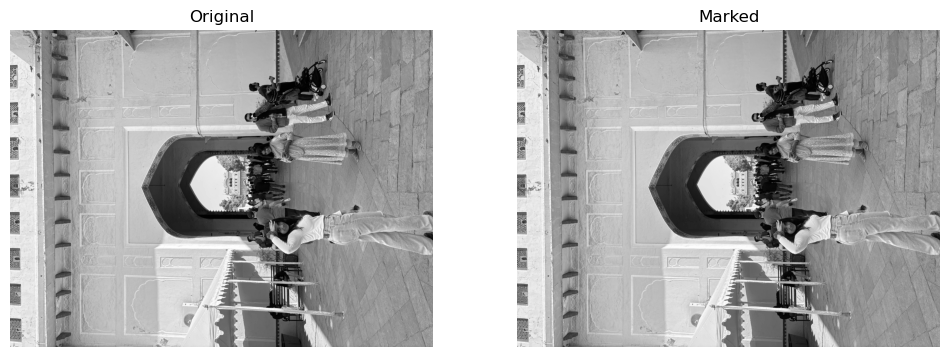

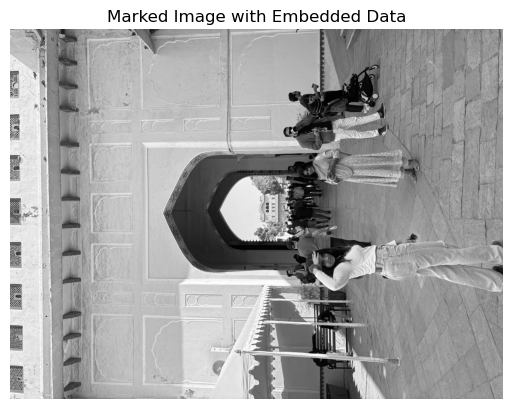

Original data: 1010101010
Extracted data: 1010101010
Image recovered successfully: False
Maximum pixel difference: 1
Average pixel difference: 0.41267295316819536


In [1]:
#code 1
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_index_map(n, delta):
    index_map = np.zeros(n, dtype=int)
    flag = np.zeros(n, dtype=bool)
    index_map[0] = 0  
    flag[0] = True    
    for i in range(1, n):  
        index_map[i] = (index_map[i-1] + delta) % n
        if flag[index_map[i]]:
            index_map[i] = (index_map[i] + 1) % n  
        flag[index_map[i]] = True  
    return index_map

def find_optimal_delta(img):
    width = img.shape[1]
    max_capacity = 0
    optimal_delta = 1
    optimal_map = None
    
    for delta in range(1, width):
        index_map = generate_index_map(width, delta)
        transformed = img[:, index_map]
        diff = custom_diff(transformed)
        hist, _ = np.histogram(diff, bins=range(-256, 257))
        peak = hist[256:].argmax()
        capacity = hist[256 + peak]
        if capacity > max_capacity:
            max_capacity = capacity
            optimal_delta = delta
            optimal_map = index_map
    print(optimal_delta,max_capacity)
        
    
    return optimal_delta, optimal_map, max_capacity

def custom_diff(arr):
    rows, cols = arr.shape
    if cols % 2 != 0:
        raise ValueError("Odd number of columns")
    
    diff = np.zeros((rows, cols // 2), dtype=int)
    for i in range(0, cols, 2):
        diff[:, i // 2] = arr[:, i].astype(int) - arr[:, i + 1].astype(int)
    
    return diff


def embed_data(img, data):
    delta, index_map, capacity = find_optimal_delta(img)
    if len(data) > capacity:
        raise ValueError(f"Data too large. Max capacity: {capacity} bits")
    
    transformed = img[:, index_map]
    plt.imshow(transformed, cmap='gray')
    plt.title('trans')
    plt.axis('off')
    plt.show()
  
    diff = custom_diff(transformed)
    
    hist, _ = np.histogram(diff, bins=range(-256, 257))
    peak = hist[256:].argmax()
    
    location_map = np.zeros_like(diff, dtype=bool)
    location_map[diff == 255] = True
    location_map[diff == -256] = True
    
    embedded = diff.copy()
    embedded[(embedded > peak) & (embedded < 255)] += 1
    embedded[(embedded < -peak) & (embedded > -256)] -= 1
    
    data_idx = 0
    for i in range(embedded.shape[0]):
        for j in range(embedded.shape[1]):
            if embedded[i, j] == peak and data_idx < len(data) and not location_map[i, j]:
                embedded[i, j] += int(data[data_idx])
                data_idx += 1
            elif embedded[i, j] == -peak and data_idx < len(data) and not location_map[i, j]:
                embedded[i, j] -= int(data[data_idx])
                data_idx += 1
    
#     reconstructed = np.zeros_like(transformed)
#     reconstructed[:, 0] = transformed[:, 0]
#     for i in range(1, reconstructed.shape[1]):
#         reconstructed[:, i] = reconstructed[:, i-1] + embedded[:, i-1]
    newt=embedded-diff
    num_rows,num_cols=newt.shape
    new_array=np.zeros((num_rows,2*num_cols),dtype=newt.dtype)
    new_array[:,::2]=newt
    finall=transformed+new_array
    
    inverse_map = np.argsort(index_map)
    marked = finall[:, inverse_map]
    plt.imshow(marked, cmap='gray')
    plt.title('Marked Image with Embedded Data')
    plt.axis('off')
    plt.show()
    
    
    return marked, delta, index_map, peak, location_map

def extract_data(marked_img, delta, index_map, peak, location_map, data_length):
    transformed = marked_img[:, index_map]
    plt.imshow(transformed, cmap='gray')
    plt.title('Marked Image with Embedded Data')
    plt.axis('off')
    plt.show()
    diff = custom_diff(transformed)
    
    extracted_data = ''
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            if not location_map[i, j]:
                if diff[i, j] == peak + 1:
                    extracted_data += '1'
                    diff[i, j] = peak
                elif diff[i, j] == peak:
                    extracted_data += '0'
                elif diff[i, j] == -peak - 1:
                    extracted_data += '1'
                    diff[i, j] = -peak
                elif diff[i, j] == -peak:
                    extracted_data += '0'
            if len(extracted_data) == data_length:
                break
        if len(extracted_data) == data_length:
            break
    
    restored_diff = diff.copy()
    restored_diff[diff == peak + 1] = peak
    restored_diff[diff == 255 - peak] = peak
    
    prop=diff-restored_diff
    num_rows,num_cols=prop.shape
    newt_array=np.zeros((num_rows,2*num_cols),dtype=prop.dtype)

    newt_array[:,::2]=prop
    finaled=transformed-newt_array
    
    inverse_map = np.argsort(index_map)
    original = finaled[:, inverse_map]
    
    return extracted_data, original

def process(path, data):
    img = np.array(Image.open(path).convert('L'))
    
    
    marked_img, delta, index_map, peak, location_map = embed_data(img, data)
    print(f"Data embedded. Image shape: {img.shape}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(marked_img, cmap='gray')
    ax2.set_title('Marked')
    ax2.axis('off')
    plt.show()
    
    extracted_data, recovered_img = extract_data(marked_img, delta, index_map, peak, location_map, len(data))
    
    
    print(f"Original data: {data}")
    print(f"Extracted data: {extracted_data}")
    print(f"Image recovered successfully: {np.array_equal(img, recovered_img)}")
    if not np.array_equal(img, recovered_img):
        diff = np.abs(img.astype(int) - recovered_img.astype(int))
        print(f"Maximum pixel difference: {np.max(diff)}")
        print(f"Average pixel difference: {np.mean(diff)}")
    
    return marked_img, recovered_img

if __name__ == "__main__":
    path = "C:/Users/anany/OneDrive/Desktop/Jaipur/Jaipur/IMG_0963.JPG"
    data = "1010101010"
    
    marked_img, recovered_img = process(path, data)
    
    Image.fromarray(marked_img.astype(np.uint8)).save("marked.png")
    Image.fromarray(recovered_img.astype(np.uint8)).save("recovered.png")
